In [ ]:
!pip install wfdb==2.2.1

     |████████████████████████████████| 94 kB 1.5 MB/s 
     |████████████████████████████████| 154 kB 34.4 MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-py3-none-any.whl size=100380 sha256=56c4afb3e5976699213085788af66e65264adfd83923490ae0666dbe30e04547
  Stored in directory: /root/.cache/pip/wheels/6d/28/c0/06a7ac9d179f38f37ad236c5d78da6e11fa3005152dcfd0d4f
Successfully built wfdb


In [ ]:
from scipy.io import loadmat
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy import stats
import os, sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings
import os
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from scipy import signal
import gc
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fft import fft, ifft, fftfreq, fftshift
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
from scipy.signal.lti_conversion import cont2discrete
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM
from keras.layers import Activation, GlobalMaxPool2D, SpatialDropout2D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load data with resampling at 250Hz and samples having equal length of 60 sec.
window_size = 220
skip = window_size
no_windows = int(15000/window_size)
no_leads = 12
def load_data_labels(input_directory, output_directory):
  print('Loading data...')

  header_files = []
  for f in os.listdir(input_directory):
    g = os.path.join(input_directory, f)
    if not f.lower().startswith('.') and f.lower().endswith('hea') and not f.lower().endswith(').hea') and os.path.isfile(g):
      header_files.append(g)

  classes = get_classes(input_directory, header_files)
  num_classes = len(classes)
  num_files = len(header_files)
  recordings = list()
  headers = list()

  # Label Extraction from header files
  print('Extracting labels...')
  labels = list()
  for i in range(num_files):
    recording, header = load_challenge_data(header_files[i])
    recording = resampling(recording)
    recording = pad_sequences(recording, maxlen=int(no_windows*window_size), truncating='post',padding="post")
    #print(recording.shape)
    for l in header:
      if l.startswith('#Dx:'):
        labels_act = np.zeros(num_classes)
        arrs = l.strip().split(' ')
        for arr in arrs[1].split(','):
          class_index = classes.index(arr.rstrip()) # Only use first positive index
          labels_act[class_index] = 1
    if labels_act.sum() == 1:
        labels.append(labels_act)
        #recordings.append(recording)
        temp = []
        for j in range(12):
            start = 0
            while start + window_size <= recording.shape[1]:
                temp.append(np.abs(fftshift(fft(recording[j, start:start+window_size]))))
                start += skip
        temp = np.array(temp, dtype=np.float32)
        recordings.append(np.reshape(temp, [no_leads,no_windows,window_size]))

    #headers.append(header)
  gc.collect()
  recordings = np.array(recordings, dtype=np.float32).reshape([-1, no_leads, no_windows, window_size, 1])
  labels = np.array(labels)
  return recordings, labels

# Load challenge data.
def load_challenge_data(header_file):
  with open(header_file, 'r') as f:
    header = f.readlines()
  mat_file = header_file.replace('.hea', '.mat')
  x = loadmat(mat_file)
  recording = np.asarray(x['val'], dtype=np.float64)
  return recording, header

# Need to understand
# Find unique classes.
def get_classes(input_directory, filenames):
  classes = set()
  for filename in filenames:
    with open(filename, 'r') as f:
      for l in f:
        if l.startswith('#Dx'):
          tmp = l.split(': ')[1].split(',')
          for c in tmp:
            classes.add(c.strip())
  return sorted(classes)

#resampling
def resampling(X):
  Y = []
  for i in range(X.shape[0]):
    Y.append(signal.resample(X[i,:], int((len(X[i,:])/500.0)*250)+1)) # Number of samples to downsample
  Y = np.reshape(Y,[12,-1])
  return Y

In [ ]:
input_directory = '/content/drive/MyDrive/China Physiological Signal Challenge 2018/Training_WFDB/'
output_directory = '/content/drive/MyDrive/China Physiological Signal Challenge 2018/Output_Directory/'

[recordings, labels] = load_data_labels(input_directory, output_directory) #recordings and labels both are in list format

print('Done.')
#print(recordings.shape)

Loading data...
Extracting labels...
Done.


In [ ]:
recordings.shape

(6401, 12, 68, 220, 1)

In [ ]:
labels[5000, :]

array([0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(recordings,labels, test_size=0.05, shuffle=True, random_state=5)

In [ ]:
print(X_train.shape)

(6080, 12, 68, 220, 1)


In [ ]:
from tensorflow.python.keras.activations import elu
class Arrithmia_classifier():

    def __init__(self):

        self.channels = no_leads
        self.times = no_windows
        self.freqs = window_size
        self.samples= X_train.shape[0]
        self.batch_size = 64


        #create 12 lead's convolutional block
        self.lead1 = self.build_channel_block()
        self.lead2 = self.build_channel_block()
        self.lead3 = self.build_channel_block()
        self.lead4 = self.build_channel_block()
        self.lead5 = self.build_channel_block()
        self.lead6 = self.build_channel_block()
        self.lead7 = self.build_channel_block()
        self.lead8 = self.build_channel_block()
        self.lead9 = self.build_channel_block()
        self.lead10 = self.build_channel_block()
        self.lead11 = self.build_channel_block()
        self.lead12 = self.build_channel_block()

        inp1 = layers.Input((self.times,self.freqs,1,))
        inp2 = layers.Input((self.times,self.freqs,1,))
        inp3 = layers.Input((self.times,self.freqs,1,))
        inp4 = layers.Input((self.times,self.freqs,1,))
        inp5 = layers.Input((self.times,self.freqs,1,))
        inp6 = layers.Input((self.times,self.freqs,1,))
        inp7 = layers.Input((self.times,self.freqs,1,))
        inp8 = layers.Input((self.times,self.freqs,1,))
        inp9 = layers.Input((self.times,self.freqs,1,))
        inp10 = layers.Input((self.times,self.freqs,1,))
        inp11 = layers.Input((self.times,self.freqs,1,))
        inp12 = layers.Input((self.times,self.freqs,1,))

        out1 = self.lead1(inp1)
        out2 = self.lead2(inp2)
        out3 = self.lead3(inp3)
        out4 = self.lead4(inp4)
        out5 = self.lead5(inp5)
        out6 = self.lead6(inp6)
        out7 = self.lead7(inp7)
        out8 = self.lead8(inp8)
        out9 = self.lead9(inp9)
        out10 = self.lead10(inp10)
        out11 = self.lead11(inp11)
        out12 = self.lead12(inp12)

        ch_out1 = self.channel_out(out1)
        ch_out2 = self.channel_out(out2)
        ch_out3 = self.channel_out(out3)
        ch_out4 = self.channel_out(out4)
        ch_out5 = self.channel_out(out5)
        ch_out6 = self.channel_out(out6)
        ch_out7 = self.channel_out(out7)
        ch_out8 = self.channel_out(out8)
        ch_out9 = self.channel_out(out9)
        ch_out10 = self.channel_out(out10)
        ch_out11 = self.channel_out(out11)
        ch_out12 = self.channel_out(out12)


        merged= layers.Concatenate()([out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11,out12])
        #final_out = layers.Attention()([merged,merged])#layers.MultiHeadAttention(num_heads=3, key_dim=2)(merged,merged)
        final_out= layers.Dense(256,activation='elu')(merged)
        final_out= layers.Dropout(0.3)(final_out)
        final_out= layers.Dense(128,activation='tanh')(final_out)
        final_out= layers.Dropout(0.3)(final_out)
        final_out= layers.Dense(32,activation='relu')(final_out)
        final_out= layers.Dropout(0.3)(final_out)
        final_out= layers.Dense(9,activation='softmax')(final_out)

        self.main = Model(inputs=[inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9,
                                  inp10,inp11,inp12],outputs=[ch_out1,ch_out2,
                                                              ch_out3,ch_out4,
                                                              ch_out5,ch_out6,
                                                              ch_out7,ch_out8,
                                                              ch_out9,ch_out10,
                                                              ch_out11,ch_out12,
                                                              final_out])
        opt = Adam(learning_rate=1e-04)
        self.main.compile(loss=['categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy','categorical_crossentropy',
                                'categorical_crossentropy']
                          ,loss_weights= [1,1,1,1,1,1,1,1,1,1,1,1,10],optimizer= opt ,metrics='accuracy')



    def build_channel_block(self):

        ecg_sig = layers.Input((self.times,self.freqs,1,))

        #beginning of conv block
        conv_out = layers.Conv2D(filters = 4,kernel_size=3,padding='valid', activation='elu')(ecg_sig)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)

        conv_out = layers.Conv2D(filters = 8,kernel_size=5,padding='valid', activation='elu')(maxpool_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)

        conv_out = layers.Conv2D(filters = 16,kernel_size=7,padding='valid', activation='elu')(maxpool_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)

        conv_out = layers.Conv2D(filters = 32,kernel_size=3,padding='valid', activation='elu')(maxpool_out)
        #maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        #batchnorm_out = layers.BatchNormalization()(maxpool_out)

        reshaped = layers.Reshape((conv_out.shape[1]*conv_out.shape[2],conv_out.shape[3]))(conv_out)

        conv_out = layers.Conv1D(filters = 32,kernel_size=7,padding='valid', activation='elu')(reshaped)
        maxpool_out = layers.MaxPool1D(pool_size=2)(conv_out)
        conv_out = layers.Conv1D(filters = 32,kernel_size=5,padding='valid', activation='elu')(maxpool_out)
        maxpool_out = layers.MaxPool1D(pool_size=2)(conv_out)
        conv_out = layers.Conv1D(filters = 32,kernel_size=3,padding='valid', activation='elu')(maxpool_out)
        maxpool_out = layers.MaxPool1D(pool_size=2)(conv_out)
        
        drop_out = layers.Dropout(0.1)(maxpool_out)
        batchnorm_out = layers.BatchNormalization()(drop_out)
        #maxpool_out = layers.MaxPool2D(pool_size=2)(batchnorm_out)
        #batchnorm_out = layers.BatchNormalization()(maxpool_out)

        flat  = layers.Flatten()(batchnorm_out)

        channel_block = Model(inputs=ecg_sig,outputs= flat)

        return channel_block

    def channel_out(self,out):
        out = layers.Dense(32,activation='relu')(out)
        ch_out = layers.Dense(9,activation='softmax')(out)
        return ch_out

In [ ]:
obj1= Arrithmia_classifier()
a = obj1.main

In [ ]:
b = obj1.build_channel_block()

In [ ]:
b.summary()

Model: "model_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_178 (InputLayer)      [(None, 68, 220, 1)]      0         
                                                                 
 conv2d_372 (Conv2D)         (None, 66, 218, 4)        40        
                                                                 
 max_pooling2d_281 (MaxPooli  (None, 33, 109, 4)       0         
 ng2D)                                                           
                                                                 
 conv2d_373 (Conv2D)         (None, 29, 105, 8)        808       
                                                                 
 max_pooling2d_282 (MaxPooli  (None, 14, 52, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_374 (Conv2D)         (None, 8, 46, 16)         628

In [ ]:
a.summary()

Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_166 (InputLayer)         [(None, 68, 220, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_167 (InputLayer)         [(None, 68, 220, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_168 (InputLayer)         [(None, 68, 220, 1)  0           []                               
                                ]                                                          

In [ ]:
arr = []
for i in range(12):
    arr.append(X_train[:,i,:,:,:])

In [ ]:
a.fit(arr,[y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train]
      ,verbose=1,epochs= 150,batch_size= 128, validation_split= 0.05, shuffle=True)

Epoch 1/150
46/46 [==============================] - 28s 602ms/step - loss: 18.8936 - dense_169_loss: 1.5656 - dense_171_loss: 1.3866 - dense_173_loss: 1.5062 - dense_175_loss: 1.2456 - dense_177_loss: 1.6065 - dense_179_loss: 1.3994 - dense_181_loss: 1.4025 - dense_183_loss: 1.3758 - dense_185_loss: 1.3965 - dense_187_loss: 1.5021 - dense_189_loss: 1.5061 - dense_191_loss: 1.5835 - dense_195_loss: 0.1417 - dense_169_accuracy: 0.4501 - dense_171_accuracy: 0.5016 - dense_173_accuracy: 0.4443 - dense_175_accuracy: 0.5467 - dense_177_accuracy: 0.4190 - dense_179_accuracy: 0.4983 - dense_181_accuracy: 0.4976 - dense_183_accuracy: 0.5078 - dense_185_accuracy: 0.4832 - dense_187_accuracy: 0.4463 - dense_189_accuracy: 0.4534 - dense_191_accuracy: 0.4262 - dense_195_accuracy: 0.9572 - val_loss: 50.0523 - val_dense_169_loss: 1.9223 - val_dense_171_loss: 1.9377 - val_dense_173_loss: 2.0787 - val_dense_175_loss: 2.3547 - val_dense_177_loss: 1.8687 - val_dense_179_loss: 1.9764 - val_dense_181_loss

KeyboardInterrupt: ignored

In [ ]:
a.fit(arr,[y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train]
      ,verbose=1,epochs= 70,batch_size= 128, validation_split= 0.05, shuffle=True)

Epoch 1/70
46/46 [==============================] - 18s 184ms/step - loss: 41.9904 - dense_75_loss: 2.5143 - dense_76_loss: 2.5239 - dense_77_loss: 2.6685 - dense_78_loss: 2.4434 - dense_79_loss: 2.4698 - dense_80_loss: 2.5454 - dense_81_loss: 2.6583 - dense_82_loss: 2.5617 - dense_83_loss: 2.5110 - dense_84_loss: 2.5508 - dense_85_loss: 2.5376 - dense_86_loss: 2.5476 - dense_89_loss: 2.2916 - dense_75_accuracy: 0.1527 - dense_76_accuracy: 0.1666 - dense_77_accuracy: 0.1444 - dense_78_accuracy: 0.1769 - dense_79_accuracy: 0.1759 - dense_80_accuracy: 0.1444 - dense_81_accuracy: 0.1395 - dense_82_accuracy: 0.1359 - dense_83_accuracy: 0.1295 - dense_84_accuracy: 0.1425 - dense_85_accuracy: 0.1442 - dense_86_accuracy: 0.1402 - dense_89_accuracy: 0.1510 - val_loss: 47.4498 - val_dense_75_loss: 3.1024 - val_dense_76_loss: 2.9792 - val_dense_77_loss: 3.0253 - val_dense_78_loss: 2.6245 - val_dense_79_loss: 2.9704 - val_dense_80_loss: 3.2667 - val_dense_81_loss: 3.4470 - val_dense_82_loss: 2.70

In [ ]:
a.fit(arr,[y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train]
      ,verbose=1,epochs= 150,batch_size= 128, validation_split= 0.05, shuffle=True)

Epoch 1/150
46/46 [==============================] - 17s 168ms/step - loss: 49.2453 - dense_45_loss: 2.4988 - dense_46_loss: 2.2929 - dense_47_loss: 2.2868 - dense_48_loss: 2.3799 - dense_49_loss: 2.4354 - dense_50_loss: 2.2961 - dense_51_loss: 2.3416 - dense_52_loss: 2.3923 - dense_53_loss: 2.6058 - dense_54_loss: 2.3258 - dense_55_loss: 2.4502 - dense_56_loss: 2.5411 - dense_59_loss: 2.0399 - dense_45_accuracy: 0.1328 - dense_46_accuracy: 0.2026 - dense_47_accuracy: 0.2001 - dense_48_accuracy: 0.1420 - dense_49_accuracy: 0.1170 - dense_50_accuracy: 0.2036 - dense_51_accuracy: 0.1641 - dense_52_accuracy: 0.1643 - dense_53_accuracy: 0.0983 - dense_54_accuracy: 0.1382 - dense_55_accuracy: 0.1378 - dense_56_accuracy: 0.1783 - dense_59_accuracy: 0.2323 - val_loss: 55.7419 - val_dense_45_loss: 3.4261 - val_dense_46_loss: 2.7803 - val_dense_47_loss: 2.9963 - val_dense_48_loss: 2.7710 - val_dense_49_loss: 2.9282 - val_dense_50_loss: 2.7520 - val_dense_51_loss: 3.5391 - val_dense_52_loss: 2.9

In [ ]:
arr_test = []
for i in range(12):
    arr_test.append(X_test[:,i,:,:,:])
del X_train, X_test

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support

In [ ]:
acc = a.evaluate(arr_test, [y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test])
pred = a.predict(arr_test)
f1scr = f1_score(y_test.argmax(1), pred[12].argmax(1), average='macro')
cnfsn = confusion_matrix(y_test.argmax(1), pred[12].argmax(1))
print("Accuracy  : {}".format(acc[26]))
print("F1_Score  : {}".format(f1scr))
print(cnfsn)

11/11 [==============================] - 1s 64ms/step - loss: 58.4704 - dense_169_loss: 2.0067 - dense_171_loss: 2.0603 - dense_173_loss: 2.2802 - dense_175_loss: 3.2143 - dense_177_loss: 2.0768 - dense_179_loss: 2.1814 - dense_181_loss: 1.8582 - dense_183_loss: 2.2214 - dense_185_loss: 2.0977 - dense_187_loss: 2.1448 - dense_189_loss: 2.2888 - dense_191_loss: 2.4349 - dense_195_loss: 3.1605 - dense_169_accuracy: 0.4486 - dense_171_accuracy: 0.4081 - dense_173_accuracy: 0.3520 - dense_175_accuracy: 0.2835 - dense_177_accuracy: 0.3863 - dense_179_accuracy: 0.4081 - dense_181_accuracy: 0.4611 - dense_183_accuracy: 0.3801 - dense_185_accuracy: 0.4050 - dense_187_accuracy: 0.3271 - dense_189_accuracy: 0.3178 - dense_191_accuracy: 0.3396 - dense_195_accuracy: 0.5919
Accuracy  : 0.5919002890586853
F1_Score  : 0.5904374148075467
[[16  5  0  0  3  1  3  0  0]
 [ 4 33  0  0  6  5  2  1  3]
 [ 0  0  3  0  0  0  0  0  0]
 [ 0  1  0  5  2  0  2  0  2]
 [ 0  1  0  1 14  2  5  3  2]
 [ 0  7  0  0  4

In [ ]:
acc = a.evaluate(arr_test, [y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test])
pred = a.predict(arr_test)
f1scr = f1_score(y_test.argmax(1), pred[12].argmax(1), average='macro')
cnfsn = confusion_matrix(y_test.argmax(1), pred[12].argmax(1))
print("Accuracy  : {}".format(acc[26]))
print("F1_Score  : {}".format(f1scr))
print(cnfsn)

11/11 [==============================] - 0s 31ms/step - loss: 26.3343 - dense_75_loss: 1.6063 - dense_76_loss: 1.7104 - dense_77_loss: 1.8597 - dense_78_loss: 1.5320 - dense_79_loss: 1.7562 - dense_80_loss: 1.9543 - dense_81_loss: 1.6083 - dense_82_loss: 1.7329 - dense_83_loss: 1.8612 - dense_84_loss: 1.9081 - dense_85_loss: 1.8659 - dense_86_loss: 1.9372 - dense_89_loss: 1.0004 - dense_75_accuracy: 0.4611 - dense_76_accuracy: 0.4330 - dense_77_accuracy: 0.3769 - dense_78_accuracy: 0.5358 - dense_79_accuracy: 0.4393 - dense_80_accuracy: 0.3925 - dense_81_accuracy: 0.4829 - dense_82_accuracy: 0.4206 - dense_83_accuracy: 0.4050 - dense_84_accuracy: 0.3427 - dense_85_accuracy: 0.3302 - dense_86_accuracy: 0.3614 - dense_89_accuracy: 0.7040
Accuracy  : 0.704049825668335
F1_Score  : 0.6457957256976864
[[21  5  1  0  0  0  0  1  0]
 [ 3 42  0  0  5  0  1  2  1]
 [ 0  0  3  0  0  0  0  0  0]
 [ 0  1  0  3  3  2  3  0  0]
 [ 0  1  0  0 22  1  0  1  3]
 [ 1 12  0  1  1  5  5  0  1]
 [ 2  0  0  0

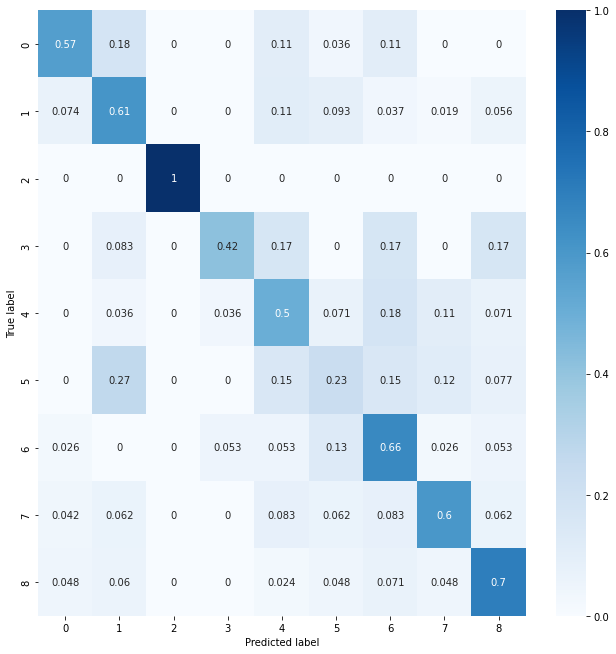

In [ ]:
c_matrix = []
for i in range(9):
    c_matrix.append(cnfsn[i, :]/(np.sum(cnfsn, axis=1))[i])
c_matrix = np.array(c_matrix, dtype=np.float32).reshape([9,9])
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
acc = a.evaluate(arr_test, [y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test])
pred = a.predict(arr_test)
f1scr = f1_score(y_test.argmax(1), pred[12].argmax(1), average='macro')
cnfsn = confusion_matrix(y_test.argmax(1), pred[12].argmax(1))
print("Accuracy  : {}".format(acc[26]))
print("F1_Score  : {}".format(f1scr))
print(cnfsn)

11/11 [==============================] - 0s 27ms/step - loss: 37.9337 - dense_45_loss: 1.9226 - dense_46_loss: 1.9232 - dense_47_loss: 2.1792 - dense_48_loss: 1.7031 - dense_49_loss: 2.0326 - dense_50_loss: 2.0188 - dense_51_loss: 1.8934 - dense_52_loss: 1.8050 - dense_53_loss: 2.0861 - dense_54_loss: 2.0381 - dense_55_loss: 1.9094 - dense_56_loss: 1.9057 - dense_59_loss: 1.4517 - dense_45_accuracy: 0.4206 - dense_46_accuracy: 0.4268 - dense_47_accuracy: 0.3645 - dense_48_accuracy: 0.4766 - dense_49_accuracy: 0.3925 - dense_50_accuracy: 0.4019 - dense_51_accuracy: 0.4579 - dense_52_accuracy: 0.4517 - dense_53_accuracy: 0.4019 - dense_54_accuracy: 0.3489 - dense_55_accuracy: 0.3894 - dense_56_accuracy: 0.3738 - dense_59_accuracy: 0.6636
Accuracy  : 0.663551390171051
F1_Score  : 0.6493822667392021
[[19  4  0  1  0  1  1  1  1]
 [ 2 35  1  0  4  4  2  2  4]
 [ 0  0  3  0  0  0  0  0  0]
 [ 0  0  0  7  0  1  2  2  0]
 [ 0  1  0  2 15  3  3  1  3]
 [ 2  4  0  0  2 11  4  1  2]
 [ 1  0  0  0

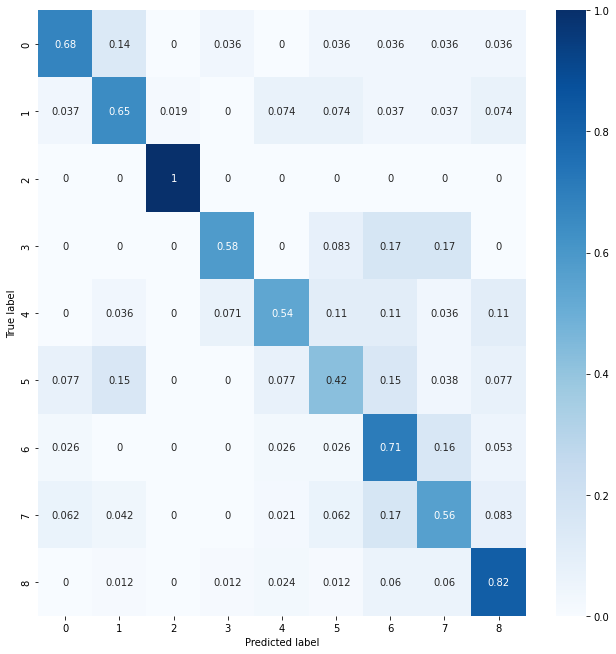

In [ ]:
c_matrix = []
for i in range(9):
    c_matrix.append(cnfsn[i, :]/(np.sum(cnfsn, axis=1))[i])
c_matrix = np.array(c_matrix, dtype=np.float32).reshape([9,9])
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
class Arrithmia_classifier():

    def __init__(self):

        self.channels = 12
        self.times = 122
        self.freqs = 122
        self.samples= 6080
        self.batch_size = 64


        #create 12 lead's convolutional block
        self.lead1 = self.build_channel_block()
        self.lead2 = self.build_channel_block()
        self.lead3 = self.build_channel_block()
        self.lead4 = self.build_channel_block()
        self.lead5 = self.build_channel_block()
        self.lead6 = self.build_channel_block()
        self.lead7 = self.build_channel_block()
        self.lead8 = self.build_channel_block()
        self.lead9 = self.build_channel_block()
        self.lead10 = self.build_channel_block()
        self.lead11 = self.build_channel_block()
        self.lead12 = self.build_channel_block()

        inp1 = layers.Input((self.times,self.freqs,1,))
        inp2 = layers.Input((self.times,self.freqs,1,))
        inp3 = layers.Input((self.times,self.freqs,1,))
        inp4 = layers.Input((self.times,self.freqs,1,))
        inp5 = layers.Input((self.times,self.freqs,1,))
        inp6 = layers.Input((self.times,self.freqs,1,))
        inp7 = layers.Input((self.times,self.freqs,1,))
        inp8 = layers.Input((self.times,self.freqs,1,))
        inp9 = layers.Input((self.times,self.freqs,1,))
        inp10 = layers.Input((self.times,self.freqs,1,))
        inp11 = layers.Input((self.times,self.freqs,1,))
        inp12 = layers.Input((self.times,self.freqs,1,))

        out1 = self.lead1(inp1)
        out2 = self.lead2(inp2)
        out3 = self.lead3(inp3)
        out4 = self.lead4(inp4)
        out5 = self.lead5(inp5)
        out6 = self.lead6(inp6)
        out7 = self.lead7(inp7)
        out8 = self.lead8(inp8)
        out9 = self.lead9(inp9)
        out10 = self.lead10(inp10)
        out11 = self.lead11(inp11)
        out12 = self.lead12(inp12)

        ch_out1 = self.channel_out(out1)
        ch_out2 = self.channel_out(out2)
        ch_out3 = self.channel_out(out3)
        ch_out4 = self.channel_out(out4)
        ch_out5 = self.channel_out(out5)
        ch_out6 = self.channel_out(out6)
        ch_out7 = self.channel_out(out7)
        ch_out8 = self.channel_out(out8)
        ch_out9 = self.channel_out(out9)
        ch_out10 = self.channel_out(out10)
        ch_out11 = self.channel_out(out11)
        ch_out12 = self.channel_out(out12)


        merged= layers.Concatenate()([out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11,out12])
        #final_out = layers.Attention()([merged,merged])#layers.MultiHeadAttention(num_heads=3, key_dim=2)(merged,merged)
        #final_out= layers.Dense(256,activation='tanh')(final_out)
        final_out= layers.Dropout(0.3)(merged)
        final_out= layers.Dense(128,activation='tanh')(final_out)
        final_out= layers.Dropout(0.3)(final_out)
        final_out= layers.Dense(32,activation='relu')(final_out)
        final_out= layers.Dropout(0.3)(final_out)
        final_out= layers.Dense(9,activation='softmax')(final_out)

        self.main = Model(inputs=[inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9,inp10,inp11,inp12],outputs=[ch_out1,ch_out2,ch_out3,ch_out4,ch_out5,ch_out6,ch_out7,ch_out8,ch_out9,ch_out10,ch_out11,ch_out12,final_out])
        opt = Adam(learning_rate=1e-04)
        self.main.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy']
                            ,loss_weights= [1,1,1,1,1,1,1,1,1,1,1,1,5],optimizer= opt ,metrics='accuracy')



    def build_channel_block(self):

        ecg_sig = layers.Input((self.times,self.freqs,1,))

        #beginning of conv block
        conv_out = layers.Conv2D(filters = 2,kernel_size=3,padding='same', activation='elu')(ecg_sig)
        conv_out = layers.Conv2D(filters = 2,kernel_size=3,padding='same', activation='elu')(conv_out)
        conv_out = layers.Conv2D(filters = 2,kernel_size=3,padding='same', activation='elu')(conv_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)

        conv_out = layers.Conv2D(filters = 4,kernel_size=5,padding='same', activation='elu')(maxpool_out)
        conv_out = layers.Conv2D(filters = 4,kernel_size=5,padding='same', activation='elu')(conv_out)
        conv_out = layers.Conv2D(filters = 4,kernel_size=5,padding='same', activation='elu')(conv_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)
        drop_out = layers.Dropout(0.2)(batchnorm_out)

        conv_out = layers.Conv2D(filters = 8,kernel_size=7,padding='same', activation='elu')(maxpool_out)
        conv_out = layers.Conv2D(filters = 8,kernel_size=7,padding='same', activation='elu')(conv_out)
        conv_out = layers.Conv2D(filters = 8,kernel_size=7,padding='same', activation='elu')(conv_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)
        drop_out = layers.Dropout(0.2)(batchnorm_out)

        conv_out = layers.Conv2D(filters = 16,kernel_size=9,padding='same', activation='elu')(maxpool_out)
        conv_out = layers.Conv2D(filters = 16,kernel_size=9,padding='same', activation='elu')(conv_out)
        conv_out = layers.Conv2D(filters = 16,kernel_size=9,padding='same', activation='elu')(conv_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)
        drop_out = layers.Dropout(0.2)(batchnorm_out)

        conv_out = layers.Conv2D(filters = 32,kernel_size=5,padding='same', activation='elu')(maxpool_out)
        conv_out = layers.Conv2D(filters = 32,kernel_size=5,padding='same', activation='elu')(conv_out)
        conv_out = layers.Conv2D(filters = 32,kernel_size=5,padding='valid', activation='elu')(conv_out)
        maxpool_out = layers.MaxPool2D(pool_size=2)(conv_out)
        batchnorm_out = layers.BatchNormalization()(maxpool_out)
        drop_out = layers.Dropout(0.2)(batchnorm_out)
        #globalpool_out = layers.GlobalAvgPool2D()(conv_out)
        #batchnorm_out = layers.BatchNormalization()(drop_out)
        #maxpool_out = layers.MaxPool2D(pool_size=2)(batchnorm_out)
        #batchnorm_out = layers.BatchNormalization()(maxpool_out)

        flat  = layers.Flatten()(batchnorm_out)

        channel_block = Model(inputs=ecg_sig,outputs= flat)

        return channel_block

    def channel_out(self,out):
        ch_out = layers.Dense(9,activation='softmax')(out)
        return ch_out